## Predicting Future Temperatures

### The problem we will tackle is predicting the max temperature for tomorrow in our city using one year of past weather data. We are going to act as if we don’t have access to any weather forecasts. What we do have access to is one year of historical max temperatures, the temperatures for the previous two days, and an estimate from a friend who is always claiming to know everything about the weather. This is a supervised, regression problem. It’s supervised because we have both the features (data for the city) and the targets (temperature) that we want to predict. 

### We will use the Random Forest Regression technique for this problem. During training, we give the random forest both the features and targets and it must learn how to map the data to a prediction. 

**Install PyDrive**

In [0]:
!pip install -U -q PyDrive

**Imports**

In [0]:
from google.colab import auth

from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth
from oauth2client.client import GoogleCredentials
import pandas as pd

**Authenticate access to google drive**

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

**Read the file on Google drive into the current notebook**

In [4]:
myfile = drive.CreateFile({'id': '1pko9oRmCllAxipZoa3aoztGZfPAD2iwj'})
myfile.GetContentFile('temps.csv')

# Read file as pandas dataframe
features = pd.read_csv('temps.csv')
features.head(5) 

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


## **Feature descriptions**

**year**: 2016 for all data points

**month**: number for month of the year

**day**: number for day of the year

**week**: day of the week as a character string

**temp_2**: max temperature 2 days prior

**temp_1**: max temperature 1 day prior

**average**: historical average max temperature

**actual**: max temperature measurement

**friend**: your friend’s prediction, a random number between 20 below the average and 20 above the average

In [5]:
print('The shape of our features is:', features.shape)

The shape of our features is: (348, 12)


**Descriptive Statistics**

In [6]:
# Descriptive statistics for each column
features.describe()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


**Data Preparation**

In [7]:
# One-hot encode the data using pandas get_dummies
features = pd.get_dummies(features)

# Display the first 5 rows of the last 12 columns
features.iloc[:,:].head(5)

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,43,50,44,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,41,50,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,43,46,47,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,44,48,46,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,46,46,46,41,0,0,0,0,0,1,0


**Split Features and Target Variable Convert Data to Arrays**

In [0]:
# Use numpy to convert to arrays
import numpy as np

# Labels are the values we want to predict
labels = np.array(features['actual'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('actual', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

**Data split into train and test sets**

In [9]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 12)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (261, 17)
Training Labels Shape: (261,)
Testing Features Shape: (87, 17)
Testing Labels Shape: (87,)


**Baseline Prediction**

In [10]:
# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('average')]

# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)

print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  4.93


**Train model**

In [0]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 12)

# Train the model on training data
rf.fit(train_features, train_labels);

**Make predictions**

In [12]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 3.51 degrees.


**Performance Metrics**

In [13]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 94.22 %.


**Variable Importance**

In [14]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: temp_1               Importance: 0.5
Variable: average              Importance: 0.32
Variable: forecast_acc         Importance: 0.04
Variable: forecast_under       Importance: 0.04
Variable: temp_2               Importance: 0.03
Variable: day                  Importance: 0.02
Variable: forecast_noaa        Importance: 0.02
Variable: friend               Importance: 0.02
Variable: month                Importance: 0.01
Variable: week_Mon             Importance: 0.01
Variable: year                 Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0


**Visualizations**

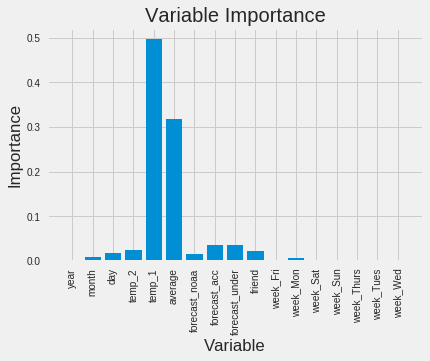

In [15]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt

%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importance');

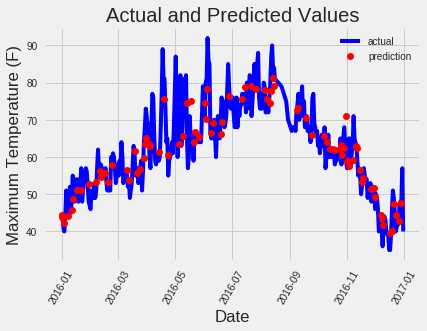

In [16]:
# Use datetime for creating date objects for plotting
import datetime

# Dates of training values
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' +
str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# Dates of predictions
months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day')]
years = test_features[:, feature_list.index('year')]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})

# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

**What were the useful variables? **

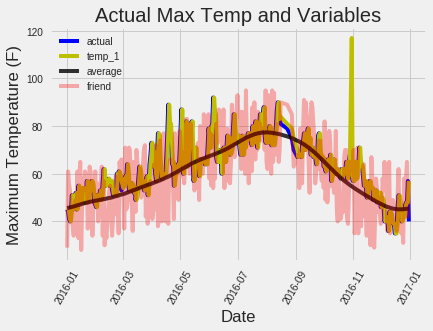

In [17]:
# Make the data accessible for plotting
true_data['temp_1'] = features[:, feature_list.index('temp_1')]
true_data['average'] = features[:, feature_list.index('average')]
true_data['friend'] = features[:, feature_list.index('friend')]

# Plot all the data as lines
plt.plot(true_data['date'], true_data['actual'], 'b-', label  = 'actual', alpha = 1.0)
plt.plot(true_data['date'], true_data['temp_1'], 'y-', label  = 'temp_1', alpha = 1.0)
plt.plot(true_data['date'], true_data['average'], 'k-', label = 'average', alpha = 0.8)
plt.plot(true_data['date'], true_data['friend'], 'r-', label = 'friend', alpha = 0.3)

# Formatting plot
plt.legend(); plt.xticks(rotation = '60');

# Lables and title
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual Max Temp and Variables');